In [2]:
pip install -U langchain-google-genai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.5/66.5 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.1/719.1 kB 24.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 234.9/234.9 kB 22.1 MB/s eta 0:00:00
  Attempting uninstall: google-auth
    Found existing installation: google-auth 2.43.0
    Uninstalling google-auth-2.43.0:
      Successfully uninstalled google-auth-2.43.0
  Attempting uninstall: google-genai
    Found existing installation: google-genai 1.55.0
    Uninstalling google-genai-1.55.0:
      Successfully uninstalled google-genai-1.55.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires google-auth==2.43.0, but you have google-auth 2.47.0 which is incompatible.
google-colab 1.0.0 requires requests==2.32.4, b

In [4]:
from google.colab import userdata
import os

os.environ["GOOGLE_API_KEY"] = userdata.get("GOOGLE_API_KEY")

In [5]:
pip install -U langchain langchain-google-genai google-generativeai


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.5/108.5 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 490.2/490.2 kB 23.1 MB/s eta 0:00:00
  Attempting uninstall: langchain-core
    Found existing installation: langchain-core 1.2.6
    Uninstalling langchain-core-1.2.6:
      Successfully uninstalled langchain-core-1.2.6
  Attempting uninstall: langchain
    Found existing installation: langchain 1.2.3
    Uninstalling langchain-1.2.3:
      Successfully uninstalled langchain-1.2.3


## Connecting to LLM chatmodel

In [8]:
from langchain_google_genai import ChatGoogleGenerativeAI

llm = ChatGoogleGenerativeAI(
    model="gemini-flash-latest",
    temperature=0.7
)

In [9]:
llm.invoke("What is the capital of India?")

AIMessage(content='The capital of India is **New Delhi**.', additional_kwargs={}, response_metadata={'finish_reason': 'STOP', 'model_name': 'gemini-2.5-flash-preview-09-2025', 'safety_ratings': [], 'model_provider': 'google_genai'}, id='lc_run--019be176-3aa2-7773-9da1-8ad9b3ab0741-0', tool_calls=[], invalid_tool_calls=[], usage_metadata={'input_tokens': 8, 'output_tokens': 9, 'total_tokens': 17, 'input_token_details': {'cache_read': 0}})

## Define state of the Graph

In [31]:
from typing_extensions import TypedDict

class State(TypedDict):

  application: str
  experience_level: str
  skill_match : str
  response: str

## Create StateGraph

In [32]:
from langgraph.graph import StateGraph, START, END

workflow = StateGraph(State)

In [33]:
from langchain_core.prompts import ChatPromptTemplate

## Define different Nodes as function

In [34]:
def categorize_experience(state: State) -> State:

  print("\nCategorizing the experience level of candidate : ")
  prompt = ChatPromptTemplate.from_template(
      "Based on the following job application, categorize the candidate as 'Entry-level', 'Mid-level' or 'Senior-level'"
      "Application : {application}"
  )
  chain = prompt | llm
  experience_level = chain.invoke({"application": state["application"]}).content
  print(f"Experience Level : {experience_level}")
  return {"experience_level" : experience_level}


def assess_skillset(state: State) -> State:

  print("\nAssessing the skillset of candidate : ")
  prompt = ChatPromptTemplate.from_template(
      "Based on the job application for a Python Developer, assess the candidate's skillset"
      "Respond with either 'Match' or 'No Match', not include any other words in response"
      "Application : {application}"
  )
  chain = prompt | llm
  skill_match = chain.invoke({"application": state["application"]}).content
  print(f"Skill Match : {skill_match}")
  return {"skill_match" : skill_match}

def schedule_hr_interview(state: State) -> State:

  print("\nScheduling the interview : ")
  return {"response" : "Candidate has been shortlisted for an HR interview."}

def escalate_to_recruiter(state: State) -> State:

  print("Escalating to recruiter")
  return {"response" : "Candidate has senior-level experience but doesn't match job skills."}

def reject_application(state: State) -> State:

  print("Sending rejecting email")
  return {"response" : "Candidate doesn't meet JD and has been rejected."}

## Adding node to Graph

In [35]:
workflow.add_node("categorize_experience", categorize_experience)
workflow.add_node("assess_skillset", assess_skillset)
workflow.add_node("schedule_hr_interview", schedule_hr_interview)
workflow.add_node("escalate_to_recruiter", escalate_to_recruiter)
workflow.add_node("reject_application", reject_application)

## Add Edges to Graph

In [36]:
# define route function

def route_app(state: State) -> str:

  if(state["skill_match"] == "Match"):
    return "schedule_hr_interview"
  elif(state["experience_level"] == "Senior-level"):
    return "escalate_to_recruiter"
  else:
    return "reject_application"

In [37]:
workflow.add_edge(START, "categorize_experience")
workflow.add_edge("categorize_experience", "assess_skillset")

workflow.add_conditional_edges(
    "assess_skillset",
    route_app,
    {
        "schedule_hr_interview": "schedule_hr_interview",
        "escalate_to_recruiter": "escalate_to_recruiter",
        "reject_application": "reject_application",
    }
)

workflow.add_edge("schedule_hr_interview", END)
workflow.add_edge("escalate_to_recruiter", END)
workflow.add_edge("reject_application", END)


In [38]:
app = workflow.compile()

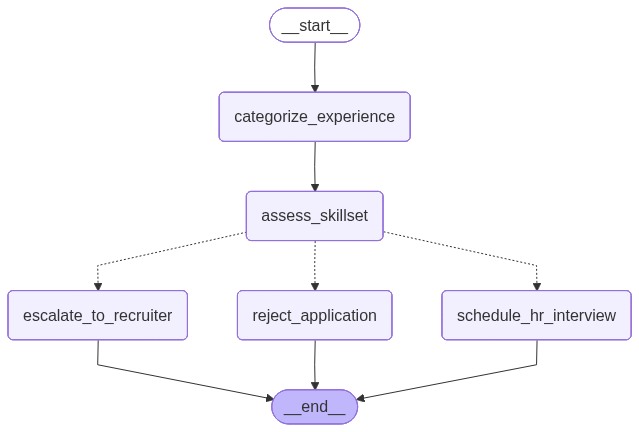

In [39]:
from IPython.display import Image, display

display(
    Image(
        app.get_graph().draw_mermaid_png()
    )
)

In [28]:
def run_candidate_screening(application: str):
  results = app.invoke({"application" : application})
  return {
      "experience_level" : results["experience_level"],
      "skill_match" : results["skill_match"],
      "response" : results["response"]
  }

In [40]:
application_text = "I have 10 years of experience in software engineering with expertise in JAVA"
results = run_candidate_screening(application_text)

print("\n\nComputed Results :")
print(f"Application: {application_text}")
print(f"Experience Level: {results['experience_level']}")
print(f"Skill Match: {results['skill_match']}")
print(f"Response: {results['response']}")


Categorizing the experience level of candidate : 
Experience Level : **Senior-level**

* *Rationale: A candidate with 10 years of experience is typically categorized as Senior-level. This duration of experience indicates a high likelihood of deep technical mastery, leadership capabilities, and the ability to architect complex solutions, which are hallmarks of a senior role.*

Assessing the skillset of candidate : 
Skill Match : [{'type': 'text', 'text': 'No Match', 'extras': {'signature': 'Cq8GAXLI2nxzHdo3Y3aa4GD8T3TiXD57Ta/A9qO589qIeq1JwEegdnj85vYx3KpNB8G8vNw7lYLqwJsFpx02Wq/cdn0J9jZ42X5DAYD/xzvuKT5qxIPAfImhlotkrY6c64NIkNaNwFOstX/oxBD7eCDLhUpe3xKBhg1PIFmxP3YQ3afKys7rk1ZHWmLaDpNTj0HheRKIWisEf8Xk++snoXbJY2XHdTI4277xr3bNbmwfEBObHP59sWZXpg0W6g4FhgcP5HsMCvF2rCmhOe9XifGEfuGl2djJFrG4IKu9qRHhn5bOUZ9dTm5Sk8T5FoaxHLFooC1kTV9eh6Y9DxVhgPKaOkqbx7/XnKD1HyXdYZ93JS/QnvHsrxCdMOVnZRCcDCayCkWiP2FmCkOePiKyh0ZcNc24xLKh+x3j6km2BUGFSVHvMKwA88uILwL32ByeFf6CvNNjb8NYkj0HpEQsMyeX5fW964QT091BSgHAEe09tC7A1LqUDxF5

In [41]:
application_text = "I have 1 year of experience in software engineering with expertise in JAVA"
results = run_candidate_screening(application_text)
print("\n\nComputed Results :")
print(f"Application: {application_text}")
print(f"Experience Level: {results['experience_level']}")
print(f"Skill Match: {results['skill_match']}")
print(f"Response: {results['response']}")


Categorizing the experience level of candidate : 
Experience Level : **Entry-level**

Assessing the skillset of candidate : 
Skill Match : [{'type': 'text', 'text': 'No Match', 'extras': {'signature': 'CrIFAXLI2nxWLVEbRV7pYJDAPplPQGxfgLdMNVIbX3nMdryhqNI/XIzdE7/EmIEUeA+lxWRoR5hoBMfh6D8tvPAmBvz5aZejgVl3LvukgfqVV113a8b4a0Wd6WRg4U5UO6pNoWwOGNl72t9V0s8qTuM6XHflEvWUOY79aFajNad8OeXWDrq+878f6UomD1W4vxzGl+G2vC+BuaKnpIEvCqELcASa8wNU+A7VXTaUAbsD7DuvaFMBy0oRd8P1BH69dNVC7PqcDrvQitRU8KARNzY5S/1eyDy9mowPRZKAGlyK7Eiqsdd5d2OCnIcxZB2hd7Bw4c0ih8a7uUJNb1rDMnmG9WDc6BZzhwgyW37QYoyYJkym2hGPGM4A9BTsd7wF50xwAy3QoryuqBkS+HKT2Ccs6Ak28/LWC3ALtMqbP2kwRn7rguLhYthkJWFkmGOpEyq9+i69ouyF1sUouLs7J0vOALHd2lSiaMqBwwwU59KHerTOWA9WPfNLe7AA08Ntk+jwzTNQr4v1FB/3BRkGPEcK31efY0w2lGkJEv8s9r7xHqLUyAZDhonfjO3loozcw4dICCFRyZtiW7m8hjxMlhKShEX1Ja/Jzf9bnIeDu7iVCVYjbAKedzcLbaT2vHKAiP4Kim9Mj5p1U2wzlTodEVIXsAr6ZE+GfA0QDv/7d2KhcbdySr/eCp1QcXNqSzI/NPEftxLtOr97FB5+aaLAo65H7Noen/jVmE0htJ1MGam9X0/6Tn3iJfykjvq4bluGzijZ7GSIfoZEfjl1LjyvJ9lQccaty

In [42]:
application_text = "I have experience in software engineering with expertise in Python"
results = run_candidate_screening(application_text)
print("\n\nComputed Results :")
print(f"Application: {application_text}")
print(f"Experience Level: {results['experience_level']}")
print(f"Skill Match: {results['skill_match']}")
print(f"Response: {results['response']}")


Categorizing the experience level of candidate : 
Experience Level : Based *only* on the statement:

**"I have experience in software engineering with expertise in Python"**

The candidate is most likely **Mid-level**.

Here is the reasoning:

1.  **"I have experience in software engineering"**: This suggests they are not **Entry-level** (who would typically say they are *seeking* experience or have *academic* experience).
2.  **"with expertise in Python"**: The use of the word "expertise" suggests a high degree of skill and practical application beyond basic coding or academic projects, which pushes them past the Entry-level mark.
3.  **Why not Senior-level?**: A Senior-level application almost always includes language related to leadership, architecture design, strategic decision-making, mentoring, managing large projects, or driving technical roadmaps. This statement is purely focused on individual technical skill ("expertise"), not broader leadership or strategic impact.

Assessin

In [43]:
application_text = "I have 5 years of experience in software engineering with expertise in C++"
results = run_candidate_screening(application_text)
print("\n\nComputed Results :")
print(f"Application: {application_text}")
print(f"Experience Level: {results['experience_level']}")
print(f"Skill Match: {results['skill_match']}")
print(f"Response: {results['response']}")


Categorizing the experience level of candidate : 
Experience Level : Based on the information provided, the candidate would most commonly be categorized as **Mid-level**.

Here is a typical breakdown of experience levels in software engineering:

*   **Entry-level:** 0–2 years
*   **Mid-level:** 3–7 years
*   **Senior-level:** 8+ years

With **5 years of experience**, the candidate falls squarely into the Mid-level range. They are expected to be fully autonomous, capable of owning mid-sized features, and potentially mentoring entry-level staff.

Assessing the skillset of candidate : 
Skill Match : No Match
Sending rejecting email


Computed Results :
Application: I have 5 years of experience in software engineering with expertise in C++
Experience Level: Based on the information provided, the candidate would most commonly be categorized as **Mid-level**.

Here is a typical breakdown of experience levels in software engineering:

*   **Entry-level:** 0–2 years
*   **Mid-level:** 3–7 ye